In [1]:
# -------------------------------------------------------------------------------
# Name: main.py
# Purpose: Pull data from twitter, perform sentiment analysis and pull stock data
#
# Author(s):    David Little
#
# Created:      04/26/2021
# Updated:
# Update Comment(s):
#
# TO DO:
#
# -------------------------------------------------------------------------------


import requests
import pandas as pd
import time
import regex as re
from datetime import datetime, timedelta

In [3]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text'],
        'retweet_count': tweet['public_metrics']['retweet_count'],
        'like_count': tweet['public_metrics']['like_count'],
        'reply_count': tweet['public_metrics']['reply_count']
#        'quote_count': tweet['public_metrics']['quote_count']
    }
    return data

In [4]:
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
tesla = re.compile(r"(?i)@Tesla(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")

In [5]:
#------------------------------------- Twitter Pull  --------------------------------------------------------

# setup the API request
endpoint = 'https://api.twitter.com/2/tweets/search/recent'  # 'https://api.twitter.com/2/tweets/search/all'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    'query': '(tesla OR tsla OR elon musk and -spacex) (lang:en)', # -is:retweet
    'max_results': '100',
    'tweet.fields': 'created_at,lang,public_metrics'
        }

In [6]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)

In [7]:
now = datetime.now()  # get the current datetime, this is our starting point
last_week = now - timedelta(days=6)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API
now

'2021-09-23T13:49:24Z'

In [8]:
df = pd.DataFrame()  # initialize dataframe to store tweets
while True:
    if datetime.strptime(now, dtformat) < last_week:
        # if we have reached 6 days ago, break the loop
        break
    pre60 = time_travel(now, 5)  # get x minutes before 'now'
    # assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)  # send the request
    time.sleep(2)
    now = pre60  # move the window 60 minutes earlier
    # iteratively append our tweet data to our dataframe
    for tweet in response.json()['data']:
        row = get_data(tweet)  # we defined this function earlier
        if row['like_count']>=0 and row['retweet_count']>=0 and row['reply_count']>=0:   #row['like_count'] >=3:
            df = df.append(row, ignore_index=True)
df

,created_at,id,like_count,reply_count,retweet_count,text
0,2021-09-23T13:49:23.000Z,1441036978368225284,1.0,0.0,0.0,There's a dude who must work in one of the sho...
1,2021-09-23T13:49:21.000Z,1441036969425833984,0.0,0.0,0.0,@abrolti only 1500 mints left of the @FrogsInD...
2,2021-09-23T13:49:20.000Z,1441036966208806920,56.0,3.0,0.0,@JeramyUtara @repkord @Tesla He knew what he w...
3,2021-09-23T13:49:19.000Z,1441036961880309769,0.0,0.0,0.0,@Any2Gregski only 1500 mints left of the @Frog...
4,2021-09-23T13:49:19.000Z,1441036959875362821,17.0,3.0,2.0,$TSLA and Rivian trucks tend to crash into oth...
...,...,...,...,...,...,...
167708,2021-09-17T13:52:33.000Z,1438863446301417474,0.0,0.0,3268.0,RT @TheSlyWolfy: The video showing Tesla's hor...
167709,2021-09-17T13:52:32.000Z,1438863444439142404,0.0,0.0,2.0,RT @TerriersVu: Tesla to Work With Global Regu...
167710,2021-09-17T13:52:31.000Z,1438863441373057028,0.0,0.0,4364.0,RT @steppewife: &gt;video of a tesla autopilot...
167711,2021-09-17T13:52:30.000Z,1438863434016165891,0.0,0.0,326.0,RT @teslaownersSV: Check out how the Tesla gla...


In [9]:
#---------------------------------------------- Sentiment Model ------------------------------------------------------

#import flair #lstm model
#sentiment_model = flair.models.TextClassifier.load('en-sentiment')

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def is_positive(tweet: str) -> bool:
    """True if tweet has positive compound sentiment, False otherwise."""
    return sia.polarity_scores(tweet)["compound"] > 0

# we will append probability and sentiment preds later
probs = []
sentiments = []
clean_tweets = []
timestamp = []
binary = []

for time in df['created_at']:
    timestamp.append(((datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%fZ')
                      - timedelta(hours = 4)) #timezone
                      + timedelta(hours = 0) #delay
                     ).strftime('%Y-%m-%d')) # %H:00:00'))

for tweet in df['text']:
# we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = tesla.sub('Tesla', tweet)
    tweet = user.sub('', tweet)
    if is_positive(tweet): binary.append(1)
    else: binary.append(0)
    #sentence = flair.data.Sentence(tweet)
    #sentiment_model.predict(sentence)
    # extract sentiment prediction
    #sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
    #if sentence.labels[0].value == 'NEGATIVE':
    #    probs.append(-1 * sentence.labels[0].score)  # numerical score 0-1
    #    binary.append(0)
    #else:
    #    probs.append(sentence.labels[0].score)  # numerical score 0-1
     #   binary.append(1)
    clean_tweets.append(tweet)
    # print(tweet)
    # print(' ')

# add probability and sentiment predictions to tweets dataframe
df['text_clean'] = clean_tweets
#df['probability'] = probs
#df['sentiment'] = sentiments
df['binary'] = binary
df['Date'] = timestamp
#df['Date'] = pd.to_datetime(df['Date'])
df

,created_at,id,like_count,reply_count,retweet_count,text,text_clean,binary,Date
0,2021-09-23T13:49:23.000Z,1441036978368225284,1.0,0.0,0.0,There's a dude who must work in one of the sho...,There's a dude who must work in one of the sho...,1,2021-09-23
1,2021-09-23T13:49:21.000Z,1441036969425833984,0.0,0.0,0.0,@abrolti only 1500 mints left of the @FrogsInD...,only 1500 mints left of the NFT drop and if ...,1,2021-09-23
2,2021-09-23T13:49:20.000Z,1441036966208806920,56.0,3.0,0.0,@JeramyUtara @repkord @Tesla He knew what he w...,Tesla He knew what he was buying. Again glad...,0,2021-09-23
3,2021-09-23T13:49:19.000Z,1441036961880309769,0.0,0.0,0.0,@Any2Gregski only 1500 mints left of the @Frog...,only 1500 mints left of the NFT drop and if ...,1,2021-09-23
4,2021-09-23T13:49:19.000Z,1441036959875362821,17.0,3.0,2.0,$TSLA and Rivian trucks tend to crash into oth...,$TSLA and Rivian trucks tend to crash into oth...,1,2021-09-23
...,...,...,...,...,...,...,...,...,...
167708,2021-09-17T13:52:33.000Z,1438863446301417474,0.0,0.0,3268.0,RT @TheSlyWolfy: The video showing Tesla's hor...,RT : The video showing Tesla's horribly unsafe...,0,2021-09-17
167709,2021-09-17T13:52:32.000Z,1438863444439142404,0.0,0.0,2.0,RT @TerriersVu: Tesla to Work With Global Regu...,RT : Tesla to Work With Global Regulators on D...,1,2021-09-17
167710,2021-09-17T13:52:31.000Z,1438863441373057028,0.0,0.0,4364.0,RT @steppewife: &gt;video of a tesla autopilot...,RT : &gt;video of a tesla autopiloting into pe...,0,2021-09-17
167711,2021-09-17T13:52:30.000Z,1438863434016165891,0.0,0.0,326.0,RT @teslaownersSV: Check out how the Tesla gla...,RT : Check out how the Tesla glass is quiet. 🤯🤯,0,2021-09-17


In [10]:
#df.to_csv("TwitterData_Retweets.csv")

In [11]:
#________________________________ Stock Data __________________________________________________________________

import yfinance as yf

#tsla = yf.Ticker("TSLA")
tsla = yf.download( "TSLA",
    start=datetime.strptime(df['created_at'].min(),'%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d'),
    end=(datetime.strptime(df['created_at'].max(),'%Y-%m-%dT%H:%M:%S.%fZ')+timedelta(days = 2)).strftime('%Y-%m-%d'),
    interval='1d' #'60m'
        )#.reset_index()
tsla_stock = tsla.pct_change().reset_index()

[*********************100%***********************]  1 of 1 completed


In [12]:
converted = []
for time in tsla_stock['Date']:
    converted.append(time.strftime('%Y-%m-%d')) #  %H:00:00'))
tsla_stock['Date'] = converted
#tsla_stock['Date'] = pd.to_datetime(tsla_stock['Date'])
tsla_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-17,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-20,-0.029836,-0.025018,-0.041840,-0.038605,-0.038605,-0.121634
2,2021-09-21,0.000313,0.003693,0.016448,0.012614,0.012614,-0.340379
3,2021-09-22,0.011895,0.011991,0.011883,0.016987,0.016987,-0.073751
4,2021-09-23,0.015426,0.005931,0.011947,0.002261,0.002261,-0.219044


In [13]:
means = df.groupby(['Date'],  as_index=False).mean()
means

,Date,like_count,reply_count,retweet_count,binary
0,2021-09-17,2.792973,0.276115,1665.225332,0.502510
1,2021-09-18,4.222144,0.303048,1646.823283,0.522415
2,2021-09-19,4.699981,0.414016,874.641551,0.444147
3,2021-09-20,5.283150,0.480372,674.836401,0.403786
4,2021-09-21,3.397978,0.326544,456.338523,0.475493
5,2021-09-22,2.924162,0.298579,472.778548,0.646659
6,2021-09-23,1.821805,0.189348,245.319557,0.628826


In [14]:
means['Date']

0    2021-09-17
1    2021-09-18
2    2021-09-19
3    2021-09-20
4    2021-09-21
5    2021-09-22
6    2021-09-23
Name: Date, dtype: object

In [15]:
tsla_stock['Date']

0    2021-09-17
1    2021-09-20
2    2021-09-21
3    2021-09-22
4    2021-09-23
Name: Date, dtype: object

In [16]:
combined = means.merge(tsla_stock, how='inner')
combined

,Date,like_count,reply_count,retweet_count,binary,Open,High,Low,Close,Adj Close,Volume
0,2021-09-17,2.792973,0.276115,1665.225332,0.502510,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-20,5.283150,0.480372,674.836401,0.403786,-0.029836,-0.025018,-0.041840,-0.038605,-0.038605,-0.121634
2,2021-09-21,3.397978,0.326544,456.338523,0.475493,0.000313,0.003693,0.016448,0.012614,0.012614,-0.340379
3,2021-09-22,2.924162,0.298579,472.778548,0.646659,0.011895,0.011991,0.011883,0.016987,0.016987,-0.073751
4,2021-09-23,1.821805,0.189348,245.319557,0.628826,0.015426,0.005931,0.011947,0.002261,0.002261,-0.219044


In [17]:
#combined['like_count'].corr(combined['Close'])
combined['binary'].corr(combined['Close'])

0.7161481239160479

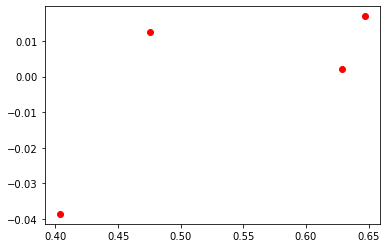

In [18]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)

# plot the data
ax.plot(combined['binary'],combined['Close'], 'ro')

In [19]:
#import tweepy

#auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
#auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

#api = tweepy.API(auth)

#public_tweets = api.home_timeline()
#for tweet in public_tweets:
#    print(tweet.text)